### advect_diffuse_3d

Use the down sample version of .npz MRI dataset process from `mri_dateset_generator.ipynb`,
all config are in yaml file.

In [5]:
# First choose a config file to apply
config_path = "configs/adpinn_full_runtest.yaml"

#### 1. Data preparation

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch

torch.set_float32_matmul_precision('medium')

from modules.ad_net import AD_Net
from modules.data_module import CharacteristicDomain, DCEMRIDataModule, VelocityDataModule
from modules.filtered_modules import create_outlier_filter_mask, FilteredDCEMRIDataModule
from utils.config_loader import Train_Config
from utils.train_wrapper import train_all_phases
from utils.visualize import draw_nifti_slices_with_time, draw_nifti_slices_with_threshold, interactive_quiver
from utils.io import load_dcemri_data, save_velocity_mat, load_DTI
%matplotlib widget
%load_ext autoreload
%autoreload 2

# load cfg from yaml path.
cfg = Train_Config(config_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [7]:

data,mask,pixdim,x,y,z,t = load_dcemri_data(cfg.dcemrinp_data_path)

char_domain = CharacteristicDomain(data.shape, mask, t, pixdim, device)

print("L_star: ",char_domain.L_star, "T_star: ", char_domain.T_star)
# batch_size is sum over data's point
c_dataset = DCEMRIDataModule(data, char_domain,  
                           batch_size=int(mask.sum()*len(t)), num_workers=cfg.dataset_num_workers, device=device)

# set up to get num_train_points
c_dataset.setup()
print("num_train_points: ", c_dataset.num_train_points, "batch_size: ", c_dataset.batch_size)

data_shape:  (51, 64, 51, 18) pixdim:  [0.3125 0.3125 0.3125]
domain_shape:  (51,) (64,) (51,) (18,)
min_c:  0.0 max_c:  362.8142
L_star:  [7.8125  9.84375 7.8125 ] T_star:  34.0
num_train_points:  158742 batch_size:  317484


In [8]:
if cfg.use_DTI:
    DTI_tensor,DTI_MD = load_DTI(char_domain, cfg.dti_data_path, data.shape[:3])
else:
    DTI_tensor = None

char_domain.set_DTI_or_coef(DTI_tensor if cfg.use_DTI else 2.4e-4)
print("Pe_g: ", char_domain.Pe_g)

Original DTI shape:  (128, 160, 128, 3, 3)
Resized DTI shape:  (51, 64, 51, 3, 3)
DTI_MD min:  0.000605409024257355 DTI_MD max:  0.02532166246860434 DTI_MD mean:  0.006678026111803901
Pe_g:  0.7065982860157951


In [9]:
if cfg.use_DTI:
    draw_nifti_slices_with_threshold(DTI_MD, brain_mask=mask)


Volume shape: (51, 64, 51) dtype: float64


interactive(children=(IntSlider(value=25, description='z', max=50), FloatSlider(value=0.006166851875605058, de…

In [10]:
# use front-tracking to get initial velocity field.
from utils.velocity_guess import front_tracking_velocity
# shape (nx, ny, nz, 3), only use half of the timestep to training, consistant with c_dataset

initial_velocity_field = front_tracking_velocity(data[:,:,:,::2], 
                                                 dt=t[2] - t[0])
# scaling, front tracking give unit in grid/min, we need to scale to characteristic velocity
initial_velocity_field *= (char_domain.pixdim / char_domain.V_star)

# draw initial velocity magnitude
vel_mag = np.linalg.norm(initial_velocity_field, axis=-1)
# print(pixdim, char_domain.domain_shape, char_domain.L_star, char_domain.T_star, char_domain.V_star)
print("velocity max and min: ", vel_mag.max(), vel_mag.min())
draw_nifti_slices_with_threshold(vel_mag)

v_dataset = VelocityDataModule(initial_velocity_field, char_domain,
                              batch_size=int(mask.sum()), num_workers=cfg.dataset_num_workers, device=device)
# set up to get num_train_points
v_dataset.setup()

velocity max and min:  0.5024794491777163 0.0
Volume shape: (51, 64, 51) dtype: float64


interactive(children=(IntSlider(value=25, description='z', max=50), FloatSlider(value=0.0912387415766716, desc…

interactive(children=(IntSlider(value=3, description='Stride', max=10, min=1), IntSlider(value=25, description…

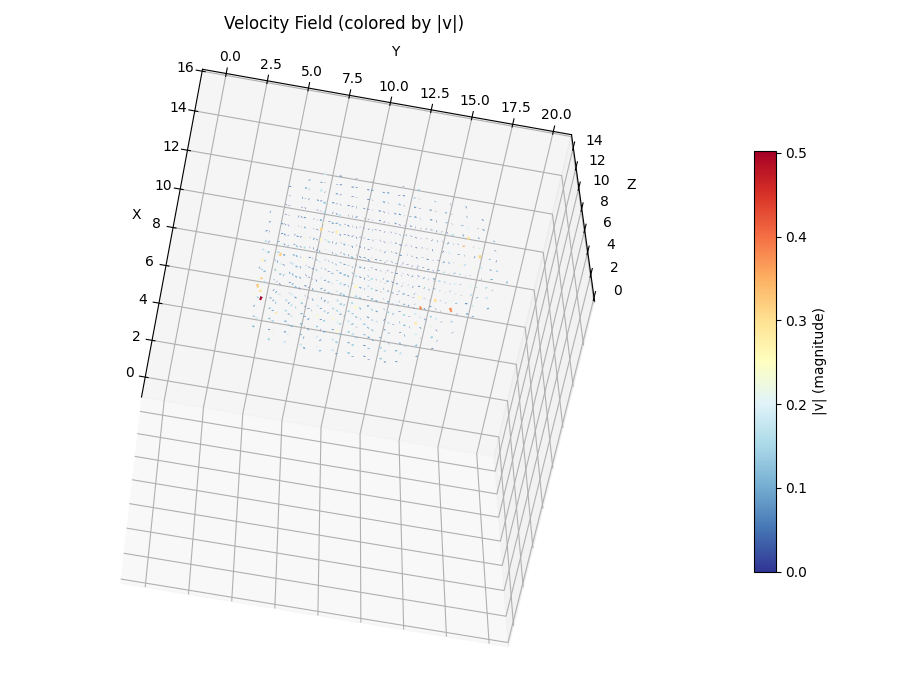

In [11]:
interactive_quiver(initial_velocity_field[:,:,:,0], initial_velocity_field[:,:,:,1], 
                   initial_velocity_field[:,:,:,2], char_domain.pixdim,default_elev=-62.76, default_azim=-10.87)


#### 2. Network definition

Here only define a base advect-diffuse PINN that learn the whole, it is reported in [J. D. Toscano et al. 2025](https://doi.org/10.1101/2025.07.30.667741) , that pure AD instead of Darcy's law cannot capture bimodal velocity distribution. 

This version has two variants:
1. simply using FNN to produce velocity field, without any pruning on solution space.
2. physics constrained divergence-free to the velocity net, so raw v_net predict the vector potential $\Phi(x,y,z)$ instead 

Also define training sequence, different variant network has different training loss.


In [12]:
# Training variant 1: init C_Net
from modules.c_trainer import CNet_Init, CNet_DenoiseInit
# Training varient 2: init V_Net (need heuristic estimate)
# 3. only optimize v + D, using advect-diffuse.
# 4. joint optimize c + v + D, using advect-diffuse
from modules.ad_trainer import ADPINN_InitV, ADPINN_PDE_V, ADPINN_Joint

# write a trainner getter to factorize.

def ADPINN_trainer_getter(train_phase, ad_net, phase_cfg={}):
    global c_dataset
    if train_phase == CNet_Init.train_phase:
        pinn_model = CNet_Init(ad_net.c_net, c_dataset.num_train_points)
        datamodule = c_dataset
    elif train_phase == CNet_DenoiseInit.train_phase:
        pinn_model = CNet_DenoiseInit(ad_net.c_net, c_dataset.num_train_points)
        datamodule = c_dataset
    elif train_phase == ADPINN_InitV.train_phase:
        pinn_model = ADPINN_InitV(ad_net, v_dataset.num_train_points)
        datamodule = v_dataset # just coarse initialie, do not need rbar.
    elif train_phase == "filter":
        batch_size = phase_cfg.get("batch_size", 200_000)
        # filter means filter on c_dataset.
        ad_net.c_net.to(device)
        valid_mask = create_outlier_filter_mask(ad_net.c_net, c_dataset.X_train, batch_size)
        c_dataset = FilteredDCEMRIDataModule(c_dataset, valid_mask)
        c_dataset.setup() # setup to get actual train_num_points
        pinn_model = None
        datamodule = c_dataset
    elif train_phase == ADPINN_PDE_V.train_phase:
        pinn_model = ADPINN_PDE_V(ad_net, c_dataset.num_train_points)
        datamodule = c_dataset
    elif train_phase == ADPINN_Joint.train_phase:
        pinn_model = ADPINN_Joint(ad_net, c_dataset.num_train_points)
        datamodule = c_dataset
    else:
        raise ValueError(f"Unknown train_phase {train_phase}")
    return pinn_model, datamodule


#### 3. Training step

- first we has initializaiton for c and v net
- then pde loss for only v net
- finally joint optimization.

In [13]:
# Instantiate the model and trainer or load from checkpoint:
ad_net = AD_Net(c_layers=[4] + [cfg.neuron_num for _ in range(cfg.hid_layer_num)] + [1],
    u_layers=[3] + [cfg.neuron_num for _ in range(cfg.hid_layer_num)] + [3],
    data=data,C_star=c_dataset.C_star,
    incompressible=False,
    char_domain=char_domain,
    positional_encoding=cfg.use_positional_encoding,
    freq_nums=cfg.positional_encode_nums,
    gamma_space=cfg.position_encode_freq_scale,
    use_learnable_D=cfg.use_learnable_D)

if cfg.do_training:
    pinn_model = train_all_phases(ad_net, ADPINN_trainer_getter, cfg)
else:
    checkpoint = torch.load(cfg.ckpt_path, map_location="cpu")
    if "state_dict" in checkpoint:
        pinn_model = ADPINN_trainer_getter(checkpoint.get("train_phase"), ad_net)[0]
        pinn_model.load_state_dict(checkpoint['state_dict'], strict=True)
    else:
        pinn_model = ADPINN_Joint(ad_net, c_dataset.num_train_points)
        ad_net.load_state_dict(checkpoint['state_dict'], strict=False)

# After training, visualize the learned velocity field and diffusivity
# Extract learned parameters
D_learned = pinn_model.ad_net.D.item()

print(f"Learned diffusivity D: {D_learned}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params | Mode 
----------------------------------------
0 | c_net | C_Net | 109 K  | train
----------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:751: Checkpoint directory tb_logs\seqtrain_ADPINN\adpinn_full_runtest_251010_1626\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type  | Params | Mode 
--------------------------------------------
0 | c_net     | C_Net | 109 K  | train
1 | noise_mlp | MLP   | 26.0 K | train
--------------------------------------------
135 K     Trainable params
0         Non-trainable params
135 K     Total params
0.542     Total estimated model params size (MB)
28        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | ad_net  | AD_Net  | 219 K  | train
1 | c_net   | C_Net   | 109 K  | train
2 | v_net   | V_Net   | 109 K  | train
3 | L2_loss | MSELoss | 0      | train
--------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.877     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode
w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=5). Set a lower value for log_every_n_steps if you want to see

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | ad_net  | AD_Net  | 219 K  | train
1 | c_net   | C_Net   | 109 K  | eval 
2 | v_net   | V_Net   | 109 K  | train
3 | L2_loss | MSELoss | 0      | train
--------------------------------------------
109 K     Trainable params
109 K     Non-trainable params
219 K     Total params
0.877     Total estimated model params size (MB)
16        Modules in train mode
15        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

w:\bigTool\Anaconda\envs\AI\lib\site-packages\lightning\pytorch\loops\fit_loop.py:527: Found 15 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | ad_net  | AD_Net  | 219 K  | train
1 | c_net   | C_Net   | 109 K  | train
2 | v_net   | V_Net   | 109 K  | train
3 | L2_loss | MSELoss | 0      | train
--------------------------------------------
219 K     Trainable params
0         Non-trainable params
219 K     Total params
0.877     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Learned diffusivity D: 2.2035112380981445


#### 4. Visualize result.
Finally we will save the velocity mat to run GLAD (get pathline figure) in matlab.

(600, 700, 3)


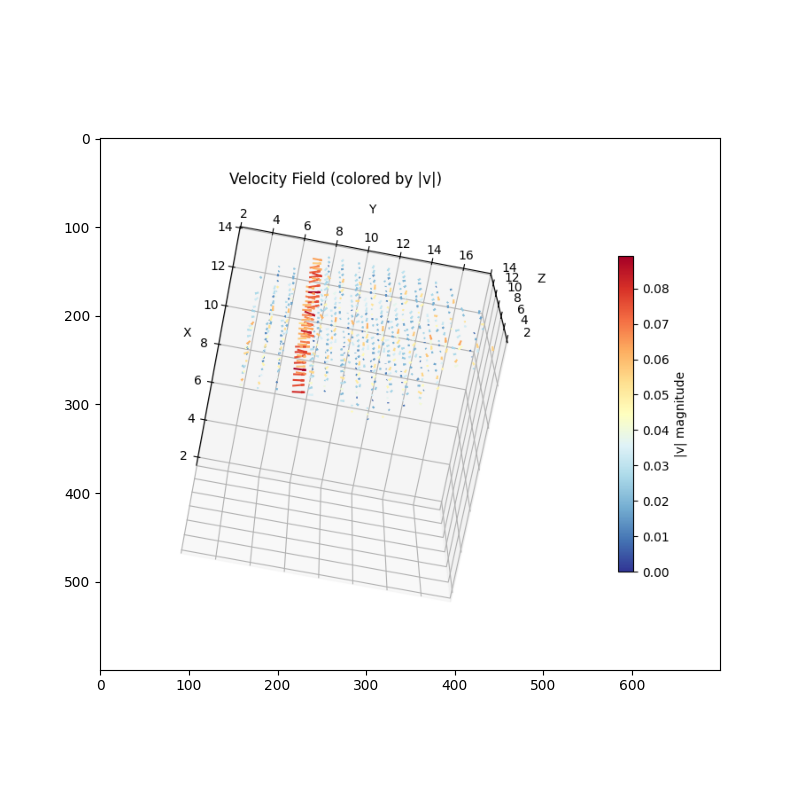

In [14]:

# 1. Extract learned velocity field on a grid for visualization
pinn_model.to(device)
# using mask to filter out the background vectors
# _ = interactive_quiver(vx, vy, vz, pixdim, default_elev=-62.76, default_azim=-10.87)
nx, ny, nz = data.shape[0], data.shape[1], data.shape[2]
v_fig, vx,vy,vz = pinn_model.v_net.draw_velocity_volume()
print(v_fig.shape)
# change vx,vy,vz from characteristic to mm/min then cell/min
vx = vx * (char_domain.V_star[0] / char_domain.pixdim[0])
vy = vy * (char_domain.V_star[1] / char_domain.pixdim[1])
vz = vz * (char_domain.V_star[2] / char_domain.pixdim[2])

plt.figure(figsize=(8,8))
plt.imshow(v_fig)
# use a grid (from real to characteristic) to extract velocity field

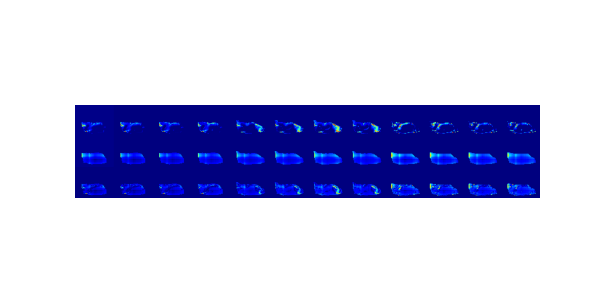

In [15]:
# use pinn_model.val_slice_4d to draw concentration slices
c_vis_list = pinn_model.c_net.draw_concentration_slices()
plt.figure(figsize=(6,3))
plt.imshow(c_vis_list, cmap='jet', vmin=0, vmax=1)
plt.axis('off')
plt.show()

torch.Size([2996352, 4])
Pred shape: (51, 64, 51, 18) True shape: (51, 64, 51, 18)


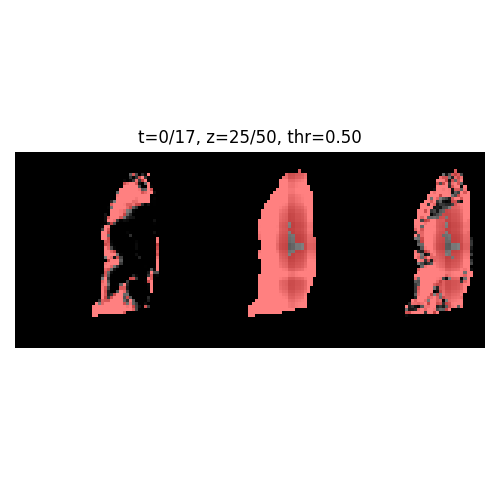

In [16]:
# 2. Extract all density field with x,y,z,t 4D grid for visualization

grid_tensor_4d = char_domain.get_characteristic_geotimedomain()  # include time part
print(grid_tensor_4d.shape)
def predict_concentration_4d(model, pts4, nx, ny, nz, nt, batch_size=200_000):
    out_list = []
    with torch.no_grad():
        for i in range(0, pts4.shape[0], batch_size):
            chunk = pts4[i:i+batch_size]
            pred = model.c_net(chunk)
            out_list.append(pred.cpu())
    C_flat = torch.cat(out_list, dim=0).numpy().reshape(nx, ny, nz, nt)
    # C_flat = torch.cat(out_list, dim=0).numpy().reshape(nx, ny, nz, nt)
    return C_flat

C_pred_4d = predict_concentration_4d(pinn_model, grid_tensor_4d, nx, ny, nz, len(t), batch_size=200_000)

# Back to physical units
C_pred_4d *= c_dataset.C_star
print("Pred shape:", C_pred_4d.shape, "True shape:", data.shape)  # (nx, ny, nz, nt)

_ = draw_nifti_slices_with_time(C_pred_4d, data, mask)
# try calculate loss with true data
# from sklearn.metrics import mean_squared_error
# mse_overall = mean_squared_error(data.flatten(), C_pred_4d.flatten())


In [17]:
# Export velocity to .mat format so that we could run GLAD using matlab
# the rOMT code require velocity reshaped to N*3 x 1, with unit cell/min
# also save D as real unit if not cfg.use_DTI, else save D_normalized as DTI enhanced
# to tell matlab how to simulate advect-diffuse equation
save_velocity_mat(vx,vy,vz,pixdim, 
                  D=pinn_model.ad_net.D.item() if not cfg.use_DTI else pinn_model.ad_net.D_normalized.item(), 
                  use_DTI=cfg.use_DTI
                  ,path=f"{cfg.result_folder}/predict_velocity.mat")

(1997568, 1)
